# Reaction-diffusion system
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [NLDC_reactionDiffusion.ipynb](https://github.com/diegoinacio/creative-coding-notebooks/blob/master/Simulation/reactionDiffusion.ipynb)
---
<font color='#CC0000'>[<b>PT-BR</b> content]</font>

Implementação de um sistema de [reação-difusão](https://en.wikipedia.org/wiki/Reaction%E2%80%93diffusion_system) com base no modelo de [Gray Scott](https://groups.csail.mit.edu/mac/projects/amorphous/GrayScott/).

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from PIL import Image
import imageio
import numpy as np
from numba import jit

Modelo matemático correspondente à reação química, definida por:
$$
\large U + 2V \rightarrow 3V \\
\large V \rightarrow P
$$
modelado pelas equações diferenciais parciais:
$$
\large \frac{\partial u}{\partial t} = r_u\nabla^2u - uv^2 + f(1-u) \\
\large \frac{\partial v}{\partial t} = r_v\nabla^2v + uv^2 - (f+k)v
$$
sendo $\large r_u$|$\large r_v$ (taxas de difusão), $\large f$ e $\large k$, constantes positivas. O $\large \nabla^2f$ é o [operador de laplace](https://pt.wikipedia.org/wiki/Laplaciano), que é a segunda derivação parcial da função [gradiente](https://pt.wikipedia.org/wiki/Gradiente), que tem aproximação discreta pelo [método das diferenças finitas](https://pt.wikipedia.org/wiki/M%C3%A9todo_das_diferen%C3%A7as_finitas) e definido por:

$$
\large \nabla^2f=\Delta f(x,y) \approx \frac{f(x, y-h)+f(x, y+h)+f(x-h, y)+f(x+h, y)-4f(x,y)}{h^2}
$$

In [2]:
@jit(nopython=True, parallel=True)
def nabla2f(Z):
    '''
    Operador de Laplace
    '''
    Zcima = Z[0:-2,1:-1]
    Zbaixo = Z[2:,1:-1]
    Zesq = Z[1:-1,0:-2]
    Zdir = Z[1:-1,2:]
    Zcentro = Z[1:-1,1:-1]
    return Zcima + Zesq + Zbaixo + Zdir - 4*Zcentro

In [3]:
@jit(nopython=True, parallel=True)
def reactionDiffusion(U, V, u, v, ru, rv, f, k, iters):
    '''
    Sistema de reação-difusão
    '''
    for i in range(iters):
        u += ru*nabla2f(U) - u*v**2 + f*(1 - u)
        v += rv*nabla2f(V) + u*v**2 - (f + k)*v
    return V

Parâmetros retirados da [aplicação online](http://www.aliensaint.com/uo/java/rd/) para $\large f$, $\large k$, $\large r_u$ e $\large r_v$, respectivamente.

In [4]:
# parâmetros com base em http://www.aliensaint.com/uo/java/rd/
parametros = {'Bacteria 1': [0.035, 0.065, 0.16, 0.08],
              'Bacteria 2': [0.035, 0.065, 0.14, 0.06],
              'Coral': [0.06, 0.062, 0.16, 0.08],
              'Fingerprint': [0.06, 0.062, 0.19, 0.05],
              'Spirals': [0.018, 0.05, 0.1, 0.1],
              'Spirals-Dense': [0.02, 0.05, 0.12, 0.08],
              'Spirals-Fast': [0.02, 0.05, 0.01, 0.16],
              'Unstable': [0.02, 0.055, 0.16, 0.08],
              'Worms 1': [0.05, 0.065, 0.16, 0.08],
              'Worms 2': [0.054, 0.063, 0.19, 0.11],
              'Zebrafish': [0.035, 0.06, 0.16, 0.08]}

## 1. Visualização da difusão em relação ao tempo
---

In [5]:
%%time
fig, ax = plt.subplots(figsize=(2048//72, 512//72))

# parâmetros para gif
N1, N2 = 128j, 512j
M1, M2 = int(N1.imag), int(N2.imag)
iters = 70
frames = 30

# inicialização do sistema RD
np.random.seed(sum(map(lambda c: ord(c), 'reação difusão')))
U = np.zeros((M1 + 2, M2 + 2)); u = U[1:-1, 1:-1]
V = np.zeros((M1 + 2, M2 + 2)); v = V[1:-1, 1:-1]
t, s = np.mgrid[-0.25:0.25:N1, -1:1:N2]
fo = 5
u += np.sin(np.pi*s*fo)*np.sin(np.pi*t*fo) >= 2**0.5/2
v += np.cos(np.pi*s*fo)*np.cos(np.pi*t*fo) >= 2**0.5/2
e = 0.4
u += np.random.random((M1, M2))*e - e
v += np.random.random((M1, M2))*e - e

f, k, ru, rv = parametros['Fingerprint']

def animation(frame):
    plt.cla(); #ax.set_ylim(-1, 1); ax.set_title('White Noise')
    RD = reactionDiffusion(U, V, u, v, ru, rv, f, k, iters)
    imshow = ax.imshow(RD, vmin=RD.min(), vmax=RD.max())
    plt.tight_layout()
    return imshow

anim = manim.FuncAnimation(fig, animation, frames=30, interval=100)

anim.save('output/NLDC_reactionDiffusion.gif', writer="imagemagick", extra_args="convert")
plt.close()

# Solve repetition problem
! magick convert _output/NLDC_reactionDiffusion.gif -loop 0 _output/NLDC_reactionDiffusion.gif
! echo GIF exported and reconverted. Disregard the message above.

MovieWriter imagemagick unavailable.


GIF exported and reconverted. Disregard the message above.
Wall time: 17.4 s


![reaction-diffusion](output/NLDC_reactionDiffusion.gif "Reaction-Diffusion")

## 2. Relação dos parâmetros *k* e *f*
---

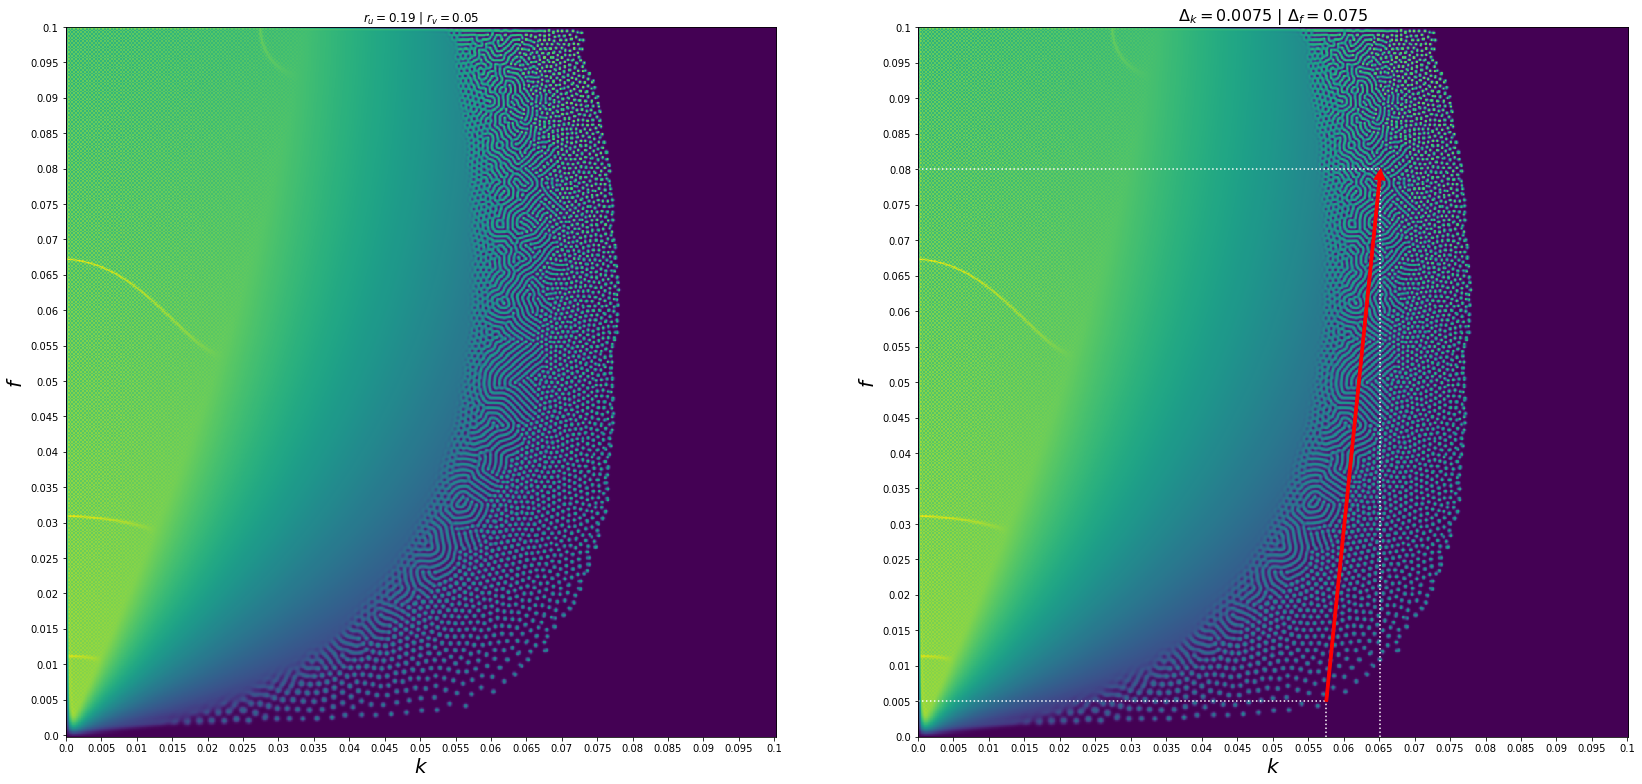

Wall time: 6min


In [6]:
%%time
fig = plt.figure(figsize=(2048//72, 1024//72))

# parâmetros de visualização
N = 1024j; M = int(N.imag)
iters = 10000
fq = 9
e = 0.4

atick = np.linspace(0, M - 1, 21)

# parâmetros para estado inicial do sistema RD
t, s = np.mgrid[-1:1:N, -1:1:N]
inicioU = np.sin(np.pi*s*fq)*np.sin(np.pi*t*fq) >= 2**0.5/2
inicioV = np.cos(np.pi*s*fq)*np.cos(np.pi*t*fq) >= 2**0.5/2

#################
# relação k x f #
#################
fig.add_subplot(121)

# inicialização do sistema RD para relação k x f
U = np.zeros((M + 2, M + 2)); u = U[1:-1, 1:-1]
V = np.zeros((M + 2, M + 2)); v = V[1:-1, 1:-1]
u += inicioU; v += inicioV
u += np.random.random((M, M))*e - e
v += np.random.random((M, M))*e - e

# parâmetros para sistema RD para relação k x f
f, k, ru, rv = parametros['Fingerprint']
f, k = np.mgrid[0.1:0:N, 0:0.1:N]
btick = [round(e, 3) for e in np.linspace(0, 0.1, 21)]

RDB = reactionDiffusion(U, V, u, v, ru, rv, f, k, iters)

# visualização do sistema RD para relação k x f
plt.imshow(RDB, vmin=RDB.min(), vmax=RDB.max())
plt.title(r'$r_u = {0}$ | $r_v = {1}$'.format(ru, rv))
plt.xticks(atick, btick); plt.xlabel(u'$k$', fontsize=20)
plt.yticks(atick, btick[::-1]); plt.ylabel(u'$f$', fontsize=20)

# visualização da relação k x f com seleção de parâmetros
ko, ki = 0.0575, 0.065
fo, fi = 0.005, 0.08

fig.add_subplot(122)
plt.imshow(RDB, extent=[0, M, 0, M], vmin=RDB.min(), vmax=RDB.max())
plt.plot([0, ko*10*M], [fo*10*M]*2, ':', color='w')
plt.plot([0, ki*10*M], [fi*10*M]*2, ':', color='w')
plt.plot([ko*10*M]*2, [0, fo*10*M], ':', color='w')
plt.plot([ki*10*M]*2, [0, fi*10*M], ':', color='w')
plt.arrow(ko*10*M, fo*10*M, (ki - ko)*10*M, (fi - fo)*10*M-16,
          width=4, head_width=16, head_length=16, color='red', zorder=2)
plt.title(r'$\Delta_k = {0}$ | $\Delta_f = {1}$'.format(ki-ko, fi-fo), fontsize=16)
plt.xticks(atick, btick); plt.xlabel(u'$k$', fontsize=20)
plt.yticks(atick, btick); plt.ylabel(u'$f$', fontsize=20)

plt.show()

## 3. Aplicação do modelo utilizando imagem como parâmetro
---

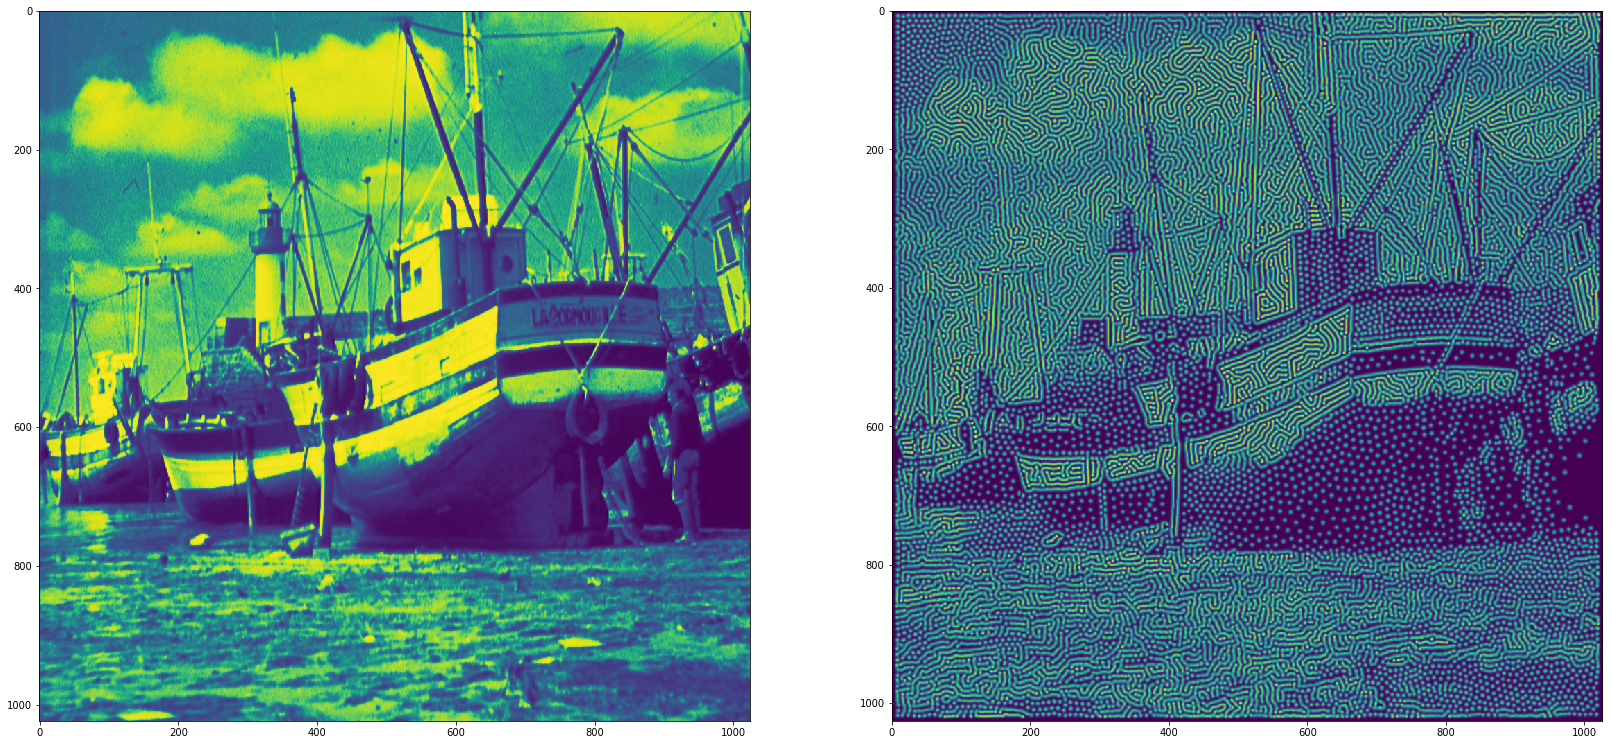

Wall time: 5min 52s


In [7]:
%%time
fig = plt.figure(figsize=(2048//72, 1024//72))

# dados para sistema RD
IMG = Image.open('../_data/ship.png')
IMG = IMG.resize((1024, 1024), Image.BILINEAR)
IMG = np.asarray(IMG, dtype=np.float32)/255
M = IMG.shape[0]
N = complex(0, M)

# equalização de histograma
flat = IMG.ravel()
sort = np.sort(flat)
search = sort.searchsorted(IMG)
IMG = search/(M**2 - 1)

# parâmetros de visualização
iters = 10000
fq = 11
e = 0.4

# parâmetros para estado inicial do sistema RD
t, s = np.mgrid[-1:1:N, -1:1:N]
inicioU = np.sin(np.pi*s*fq)*np.sin(np.pi*t*fq) >= 2**0.5/2
inicioV = np.cos(np.pi*s*fq)*np.cos(np.pi*t*fq) >= 2**0.5/2

#####################################
# visualização da imagem de entrada #
#####################################
fig.add_subplot(121)
plt.imshow(IMG, vmin=IMG.min(), vmax=IMG.max())

##############################
# visualização do sistema RD #
##############################
fig.add_subplot(122)

# inicialização do sistema RD para relação ru x rv
U = np.zeros((M + 2, M + 2)); u = U[1:-1, 1:-1]
V = np.zeros((M + 2, M + 2)); v = V[1:-1, 1:-1]
u += inicioU; v += inicioV
u += np.random.random((M, M))*e - e
v += np.random.random((M, M))*e - e

# visualização da relação k x f com seleção de parâmetros
f, k, ru, rv = parametros['Fingerprint']
ko, ki = 0.0575, 0.065
fo, fi = 0.005, 0.08
f = IMG; f = f*(fi - fo) + fo
k = IMG; k = k*(ki - ko) + ko

RD = reactionDiffusion(U, V, u, v, ru, rv, f, k, iters)

plt.imshow(RD, vmin=RD.min(), vmax=RD.max())

plt.show()

## 4. Aplicação do modelo utilizando imagem RGB
---

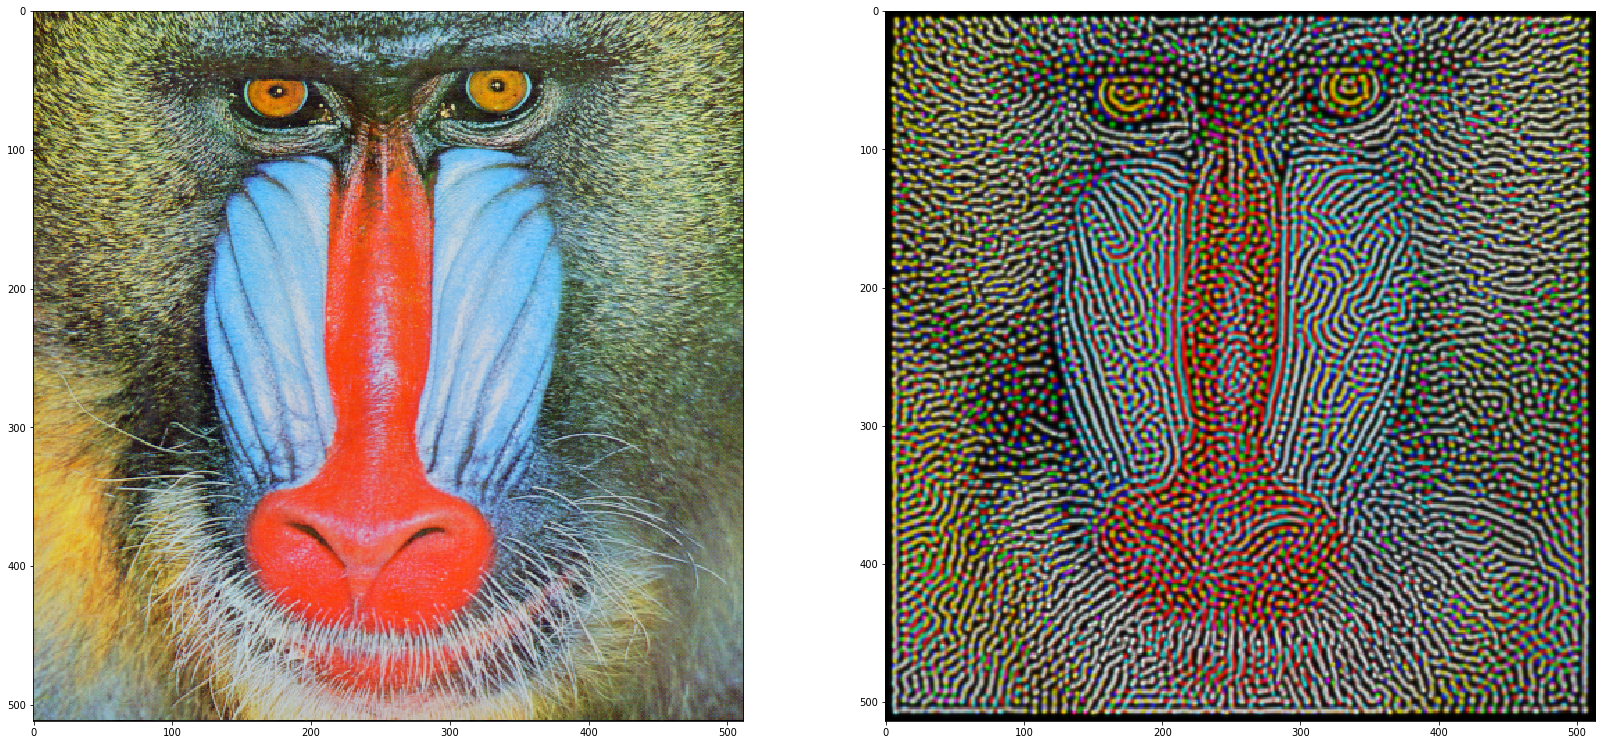

Wall time: 5min 18s


In [8]:
%%time
fig = plt.figure(figsize=(2048//72, 1024//72))

# dados para sistema RD
RGB = Image.open('../_data/babuino.png')
#RGB = RGB.resize((1024, 1024), Image.BILINEAR)
RGB = np.asarray(RGB, dtype=np.float32)/255
R = RGB[:,:,0]; G = RGB[:,:,1]; B = RGB[:,:,2]
M = R.shape[0]; N = complex(0, M)

# parâmetros de visualização
iters = 10000
fq = 11
e = 0.4

# parâmetros para estado inicial do sistema RD
t, s = np.mgrid[-1:1:N, -1:1:N]
inicioU = np.sin(np.pi*s*fq)*np.sin(np.pi*t*fq) >= 2**0.5/2
inicioV = np.cos(np.pi*s*fq)*np.cos(np.pi*t*fq) >= 2**0.5/2

#####################################
# visualização da imagem de entrada #
#####################################
fig.add_subplot(121)
plt.imshow(RGB)

##############################
# visualização do sistema RD #
##############################
fig.add_subplot(122)

# visualização da relação k x f com seleção de parâmetros
f, k, ru, rv = parametros['Fingerprint']
ko, ki = 0.0575, 0.065
fo, fi = 0.005, 0.08
RDRGB = []
for C in [R, G, B]:
    U = np.zeros((M + 2, M + 2)); u = U[1:-1, 1:-1]
    V = np.zeros((M + 2, M + 2)); v = V[1:-1, 1:-1]
    u += inicioU; v += inicioV
    u += np.random.random((M, M))*e - e
    v += np.random.random((M, M))*e - e

    # parâmetros para sistema RD com base em k x f
    f = C; f = f*(fi - fo) + fo
    k = C; k = k*(ki - ko) + ko

    RD = reactionDiffusion(U, V, u, v, ru, rv, f, k, iters)
    RDRGB += [(RD - RD.min())/(RD.max() - RD.min())]

plt.imshow(np.dstack(RDRGB))

plt.show()